# Variational Autoencoder (VAE)

Useful links: 
* original paper http://arxiv.org/abs/1312.6114
* helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this seminalr we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset (LFW) (http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)

You should download prepared dataset using the following link: https://yadi.sk/d/7XGFzVlrqctwT

## Prepare the data

In [164]:
import numpy as np

data = np.load("/Users/fedor/research/facewarping/frontal_smiling_45x45.npz")
X_train = data["images"][:10000].reshape((10000,-1))
print(X_train.shape)
X_val = data["images"][10000:].reshape((-1,X_train.shape[1]))
print(X_val.shape)

image_h = data["images"].shape[1]
image_w = data["images"].shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [165]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [166]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

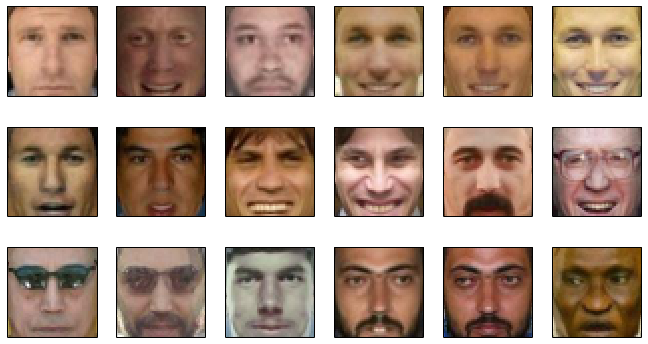

In [167]:
plot_gallery(X_train, image_h, image_w)

In [3]:
import sys
sys.path = ['', '/usr/local/lib/python2.7/site-packages/setuptools-12.0.5-py2.7.egg', '/usr/local/lib/python2.7/site-packages/JCC-2.20-py2.7-macosx-10.10-x86_64.egg', '/usr/local/lib/python2.7/site-packages/lucene-4.9.0-py2.7-macosx-10.10-x86_64.egg', '/usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib/python27.zip', '/usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib/python2.7', '/usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-darwin', '/usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac', '/usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac/lib-scriptpackages', '/usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-tk', '/usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-old', '/usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-dynload', '/usr/local/lib/python2.7/site-packages', '/Library/Python/2.7/site-packages/protobuf-3.0.0a1-py2.7.egg', '/Library/Python/2.7/site-packages/Keras-0.0.1-py2.7.egg', '/Library/Python/2.7/site-packages/h5py-2.5.0-py2.7-macosx-10.10-intel.egg', '/Library/Python/2.7/site-packages/sparselsh-0.0.2-py2.7.egg', '/Library/Python/2.7/site-packages', '/Library/Python/2.7/site-packages']

In [25]:
import theano
import theano.tensor as T

# Just Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [168]:
import lasagne

input_X = T.matrix("X")

input_shape = [None,image_h*image_w*3]

In [169]:
HU_encoder = 2000
HU_decoder = 2000
dimZ = 1000

# define the network

input_layer = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)

dense_enc = lasagne.layers.DenseLayer(input_layer,num_units=HU_encoder,
                                   nonlinearity = lasagne.nonlinearities.rectify,
                                   W = lasagne.init.GlorotUniform(),
                                   b = lasagne.init.Constant(0),
                                   name = "hidden_layer_encoder")

dense_z = lasagne.layers.DenseLayer(dense_enc,num_units=dimZ,
                                   W = lasagne.init.GlorotUniform(),
                                   b = lasagne.init.Constant(0),
                                   name = "hidden_layer_encoder")

dense_dec = lasagne.layers.DenseLayer(dense_z,num_units=HU_decoder,
                                   nonlinearity = lasagne.nonlinearities.rectify,
                                   W = lasagne.init.GlorotUniform(),
                                   b = lasagne.init.Constant(0),
                                   name = "hidden_layer_encoder")

dense_out = lasagne.layers.DenseLayer(dense_dec,num_units=input_shape[1],
                                   nonlinearity = lasagne.nonlinearities.sigmoid,
                                   W = lasagne.init.GlorotUniform(),
                                   b = lasagne.init.Constant(0),
                                   name = "hidden_layer_encoder")

In [170]:
# create prediction variable
prediction = lasagne.layers.get_output(dense_out)

tmp  = lasagne.layers.get_output(input_layer)

# create loss function
loss = lasagne.objectives.squared_error(prediction, input_X).mean()

# create parameter update expressions
params = lasagne.layers.get_all_params(dense_out, trainable=True)
updates = lasagne.updates.adam(loss, params, learning_rate=0.001)

# compile training function that updates parameters and returns training loss
# this will take a while
train_fn = theano.function([input_X], loss, updates=updates)
test_fn = theano.function([input_X], prediction)
tmp_fn = theano.function([input_X], tmp)

In [171]:
def iterate_minibatches(inputs, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

KeyboardInterrupt: 

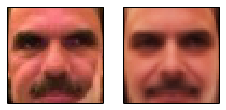

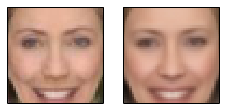

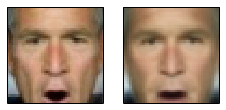

In [175]:
from time import time

from IPython import display

for epoch in range(100):
    epoch_loss = 0
    start = time()
    for batch in iterate_minibatches(X_train, 100):
        epoch_loss += train_fn(batch)
        pred = test_fn(batch)
        #plt.clf()
        plot_gallery([batch[0],pred[0]], image_h, image_w, n_row=1, n_col=2)
        #display.clear_output(wait=True)
        #display.display(plt.gcf())
    print("Epoch %d: Loss %g Time: %g" % (epoch + 1, epoch_loss / len(X_train), time()-start ))

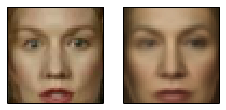

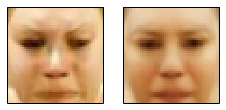

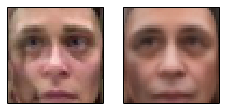

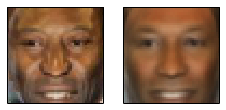

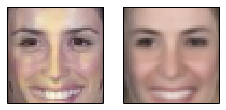

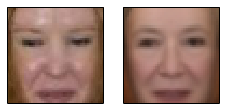

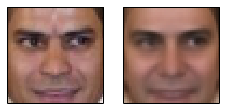

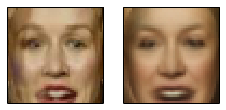

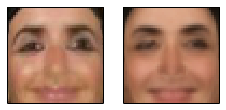

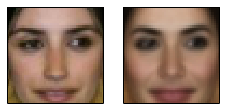

In [176]:
for batch in iterate_minibatches(X_val[:10], 1):
    pred = test_fn(batch)
    plot_gallery([batch[0],pred], image_h, image_w, n_row=1, n_col=2)

In [12]:
train_data["images"].shape

(10143, 3, 48, 48)

In [ ]:
dimZ = 200
HU_decoder = 1000
HU_encoder = HU_decoder

batch_size = 100
L = 1
learning_rate = 0.01

if args.double:
    print 'computing hidden layer to train new AE on'
    prev_params = np.load(args.double)
    data = (np.tanh(data.dot(prev_params[0].T) + prev_params[5].T) + 1) /2
    x_test = (np.tanh(x_test.dot(prev_params[0].T) + prev_params[5].T) +1) /2

[N,dimX] = data.shape
encoder = VA(HU_decoder,HU_encoder,dimX,dimZ,batch_size,L,learning_rate)


if args.double:
    encoder.continuous = True

print "Creating Theano functions"
encoder.createGradientFunctions()

print "Initializing weights and biases"
encoder.initParams()
lowerbound = np.array([])
testlowerbound = np.array([])

begin = time.time()
for j in xrange(1500):
    encoder.lowerbound = 0
    print 'Iteration:', j
    encoder.iterate(data)
    end = time.time()
    print("Iteration %d, lower bound = %.2f,"
          " time = %.2fs"
          % (j, encoder.lowerbound/N, end - begin))
    begin = end

    if j % 5 == 0:
        print "Calculating test lowerbound"
        testlowerbound = np.append(testlowerbound,encoder.getLowerBound(x_test))